# An In-depth Exploration of US Job Market by analyzing LinkedIn Job Postings using Natural Language Processing Techniques

## Data ingestion and preprocesing
We firstly need to read the webscraped dataset and explore its contents before we begin the analysis.
For a better understanding of one domain we will focus on the jobs regarding the IT industry.

In [83]:
# Importing necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
import re
import json
from ollama import chat
from pydantic import BaseModel, Field
from typing import List
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
# import plotly.express as px

In [26]:
# Read the dataset
data = pd.read_csv('/Users/juliabarsow/Desktop/thesis/project_code/postings.csv')

In [27]:
# Check how many descriptions are missing as this is the most important column
print("Missing rows of description: ",data['description'].isnull().sum())

# Drop rows with missing descriptions
data = data.dropna(subset=['description'])

Missing rows of description:  7


In [ ]:
# List of titles to take into account in our project
# 'Project Manager' was excluded as it contained also non-IT related job postings
titles_to_classify = [
    'Full Stack Engineer',
    'Java Architect',
    'Intern- Business Analytics',
    'Frontend Engineer',
    'Machine Learning Engineer',
    'Junior Project Manager',
    'Azure Data Engineer',
    'Sr. Project Engineer',
    'Junior Business Analyst',
    'Cloud / .NET Developer',
    'Enterprise Data & Analytics Infrastructure Manager',
    'Computer Scientist',
    'DevOps Engineer',
    'Front end specialist',
    'Project Engineer',
    'Data Architect',
    'Data Analyst',
    'Java architect / Lead Java developer',
    'Enterprise Data & Analytics Infrastructure Manager',
    'Senior Software Engineer',
    'Web Developer',
    'Software Implementation Program Manager',
    'Test Engineer',
    'Sr Software Engineer',
    'IT QA Engineer II',
    'Sr. Business Analyst/Tester',
    'Senior Developer – React Native',
    'Cloud DevOps Engineer',
    'Senior Analyst, Data & Analytics',
    'Senior Business Analyst',
    'Engineering Project Manager / Project Manager',
    'Java full Stack Engineer',
    'backend Java developer',
    'Data Science Software Engineer',
    'Data Engineer/ETL'
]

# Filter the dataset to include only the specified titles
data = data[data['title'].isin(titles_to_classify)].reset_index(drop=True)

<Axes: title={'center': 'Job Title Distribution'}, xlabel='title'>

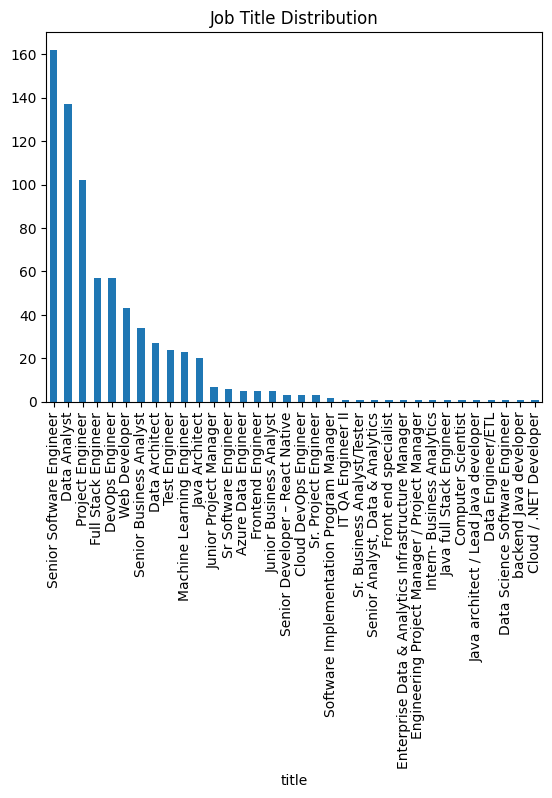

In [59]:
data['title'].value_counts().plot(kind='bar', title='Job Title Distribution')

In [64]:
# Make a copy of dataset for further processing and save only title and description columns
df = data.copy()
df = df[['title', 'description']]

In [164]:
def classify_job_titles(df: pd.DataFrame) -> pd.DataFrame:
    """
    Adds a new column 'general job classification' to a DataFrame based on 
    keywords found in the 'title' column.

    The classification logic applies rules in a specific order of precedence
    to handle complex or overlapping job titles.

    Args:
        df: The input pandas DataFrame containing a 'title' column.

    Returns:
        The modified DataFrame with the new 'general job classification' column.
    """
    if 'title' not in df.columns:
        print("Error: DataFrame must contain a 'title' column.")
        return df

    # Convert titles to lowercase for case-insensitive matching
    titles_lower = df['title'].str.lower().fillna('')

    # Use a function to apply classification rules with precedence
    def get_classification(title: str) -> str:
        """Determines the classification based on keywords in order of importance."""

        # 1. Project Management
        # Check for Program Manager or Project Manager/Engineer first
        if 'program manager' in title or 'project manager' in title or 'project engineer' in title:
            return 'Project Management'

        # 2. Data & Analytics (Includes specialized data engineering/ML roles)
        if ('data' in title and ('engineer' in title or 'analyst' in title or 'architect' in title)) or \
           'machine learning' in title or 'analytics' in title or 'etl' in title or 'data science' in title:
            return 'Data & Analytics'

        # 3. Business Analysis
        if 'business analyst' in title:
            return 'Business Analysis'
        
        # 4. Technical Architecture (Catch-all for non-data architects)
        if 'architect' in title:
            return 'Technical Architecture'

        # 5. Software Development / Engineering (The catch-all for core tech roles)
        if 'software engineer' in title or 'developer' in title or 'devops' in title or \
           'full stack' in title or 'web developer' in title or 'frontend' in title or \
           'test engineer' in title or 'qa engineer' in title or 'computer scientist' in title or 'front end' in title:
            return 'Software Development / Engineering'

        # Default classification
        return 'Other/Unclassified'

    # Apply the classification function to the lowercase titles
    df['general job classification'] = titles_lower.apply(get_classification)
    
    return df

In [66]:
df = classify_job_titles(df)

In [67]:
df['general job classification'].value_counts()

general job classification
Software Development / Engineering    366
Data & Analytics                      197
Project Management                    115
Business Analysis                      40
Technical Architecture                 21
Name: count, dtype: int64

<Axes: title={'center': 'Job Type Distribution'}, xlabel='general job classification'>

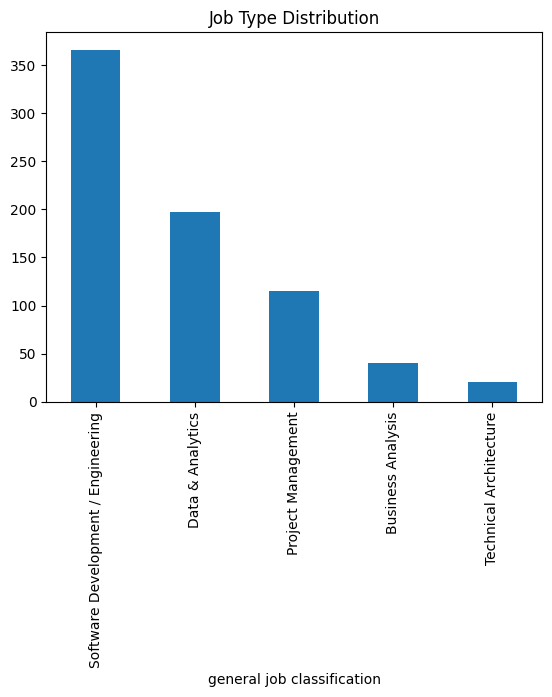

In [79]:
df['general job classification'].value_counts().plot(kind='bar', title='Job Type Distribution')

## Skill Extraction and Clustering

### Objective: Extract required skills from job descriptions and cluster them to identify common skill sets across industries.

Research Questions:

- What are the most in-demand skills across different sectors?

-  How do skill requirements differ by salary range or job title?

-  What are the salary ranges in different sectors and job positions?


### We will use Ollama: https://ollama.com/ for the skill extraction

In [ ]:
# Run these commands in terminal to set up ollama and run the model
!pip install ollama
!python3 -m ollama pull llama3.2
!python3 -m ollama run granite3.2:8b

In [68]:
# Define the desired output structure using Pydantic
# This creates a JSON Schema that Ollama is forced to follow.
class JobRequirements(BaseModel):
    """A structured model to hold the extracted skills and requirements from a job posting."""
    skills: List[str] = Field(
        ..., 
        description="A list of specific, technical, or soft skills required. E.g., 'Python', 'Machine Learning', 'Problem-Solving'."
    )
    requirements: List[str] = Field(
        ..., 
        description="A list of formal requirements, like years of experience, educational degrees, or specific certifications. E.g., 'Bachelor's Degree in Computer Science', '5+ years of experience with Kafka', 'AWS Certified'."
    )

In [69]:
# Define the prompt and configuration for Ollama
def extract_skills_requirements(job_post: str, model_name: str = "llama3.2") -> JobRequirements:
    """
    Sends the job posting to an Ollama model and extracts structured data.
    """
    
    # Generate the JSON schema from the Pydantic model
    schema = JobRequirements.model_json_schema()

    # The system prompt guides the model's behavior
    system_prompt = (
        "You are an expert HR data extraction bot. Your task is to accurately "
        "extract the required skills and formal requirements from the provided job posting. "
        "Do not include any commentary or additional text. "
        "The output MUST conform strictly to the provided JSON schema."
    )
    
    # The user prompt contains the data to be analyzed
    user_prompt = f"Analyze the following job posting and return the extracted data:\n\n---\n{job_post}"
    
    print(f"--- Sending request to Ollama with model: {model_name} ---")

    try:
        response = chat(
            model=model_name,
            messages=[
                {'role': 'system', 'content': system_prompt},
                {'role': 'user', 'content': user_prompt}
            ],
            # This is the key setting for structured output!
            format=schema,
            # Use temperature 0 for deterministic, reliable extraction
            options={'temperature': 0}
        )
        
        # The model's content is a JSON string conforming to the schema
        json_string = response['message']['content']
        
        # Validate and convert the JSON string back into a Pydantic object
        extracted_data = JobRequirements.model_validate_json(json_string)
        
        return extracted_data

    except Exception as e:
        print(f"An error occurred: {e}")
        print("Ensure Ollama server is running and the model is pulled.")
        return None

In [70]:
# Add extracted skills and formal requirements to the DataFrame
def append_skills_requirements(df: pd.DataFrame) -> pd.DataFrame:
    """
    Extracts skills and formal requirements from each job description in the DataFrame
    and appends them as new columns.

    Args:
        df: The input DataFrame with a 'description' column.

    Returns:
        The modified DataFrame with 'skills' and 'formal_requirements' columns.
    """
    skills_list = []
    requirements_list = []

    for i, job_posting_text in enumerate(df['description']):
        print(f"Processing row {i + 1}/{len(df)}...")
        result = extract_skills_requirements(job_posting_text)
        if result:
            skills_list.append(result.skills)
            requirements_list.append(result.requirements)
        else:
            skills_list.append([])  # Append empty list if extraction fails
            requirements_list.append([])

    # Add the extracted data as new columns
    df['skills'] = skills_list
    df['formal_requirements'] = requirements_list

    return df

In [71]:
df_skills = append_skills_requirements(df)

Processing row 1/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 2/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 3/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 4/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 5/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 6/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 7/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 8/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 9/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 10/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 11/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 12/739...
--- Sending request to Ollama with model: llama3.2 ---
Processing row 13/739...
--- Sending request to O

In [72]:
df_skills.to_csv('job_postings_with_skills.csv', index=False)

### Test the result of llama prediction - how valuable is this classification how to check it? can we do sth automated instead of manual?
Because we have no labeled dataset with skills we will use manual validation to check if the skills exctracted are correct

## Clustering skills

### In terminal/command line - Install and load the largest available SpaCy model:

python -m spacy download en_core_web_lg 

Prepare the Unique Skills List (Low-Effort Cleaning)
Filter your entire dataset's extracted skills to create a single list of unique terms, which is the input for vectorization.

Using Pandas and basic string methods to clean and deduplicate the skills from df['extracted_skills'] column.

In [ ]:
# Explode the list column into individual rows, keeping the index.
# Convert all skills to lowercase for standardization.
# Drop missing/empty values (if any).
unique_skills_series = df_skills['skills'].explode().str.lower().dropna().drop_duplicates()
unique_skills_list = unique_skills_series.tolist()

# Filter out very rare, noisy skills
# Only keep skills that appear in at least 3 job postings (adjust N as needed)
skill_counts = df_skills['skills'].explode().str.lower().value_counts()
frequent_skills = skill_counts[skill_counts >= 3].index.tolist()
unique_skills_list = [skill for skill in unique_skills_list if skill in frequent_skills]

print(f"Number of skills to cluster: {len(unique_skills_list)}")

Number of skills to cluster: 434


In [170]:
unique_skills_list[:10]  # Display the first 10 unique skills

['javascript/typescript',
 'react',
 'node.js',
 'python',
 'express.js',
 'relational databases',
 'nosql databases',
 'html5',
 'css3',
 'cloud platforms']

# First clustering approach - SpaCy Vector embedding

Fast Vector Generation (Low Computational Cost)
This is the fastest step. SpaCy simply looks up the pre-computed vector for each skill.

Generate a vector for every unique skill.

In [ ]:
# Load the model with vectors
nlp = spacy.load("en_core_web_lg")

In [174]:
# Use a list comprehension to get the vector for each skill
# .vector provides the 300-dimensional vector from the en_core_web_lg model
skill_vectors = np.array([nlp(skill).vector for skill in unique_skills_list])

# Scale the skill vectors
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_skill_vectors = scaler.fit_transform(skill_vectors)

Simple KMeans Clustering
KMeans is computationally fast and easy to interpret.

Apply KMeans to the skill_vectors. Start with a reasonable number of clusters, then check the optimal number.

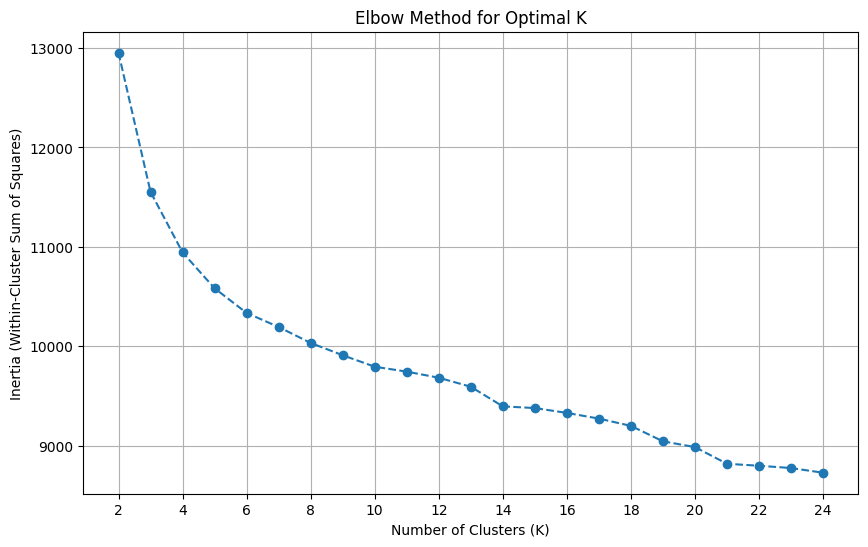

In [181]:
# Define the range of K values to test
k_range = range(2, 25) 
inertia = []

# Calculate inertia for each K
for k in k_range:
    kmeans = KMeans(
        n_clusters=k, 
        random_state=42
    )
    # Fit the model to the skill vectors
    kmeans.fit(skill_vectors)
    # Append the inertia (WSS) to the list
    inertia.append(kmeans.inertia_)

# Plotting the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.xticks(k_range[::2]) # Show every second tick mark for clarity
plt.grid(True)

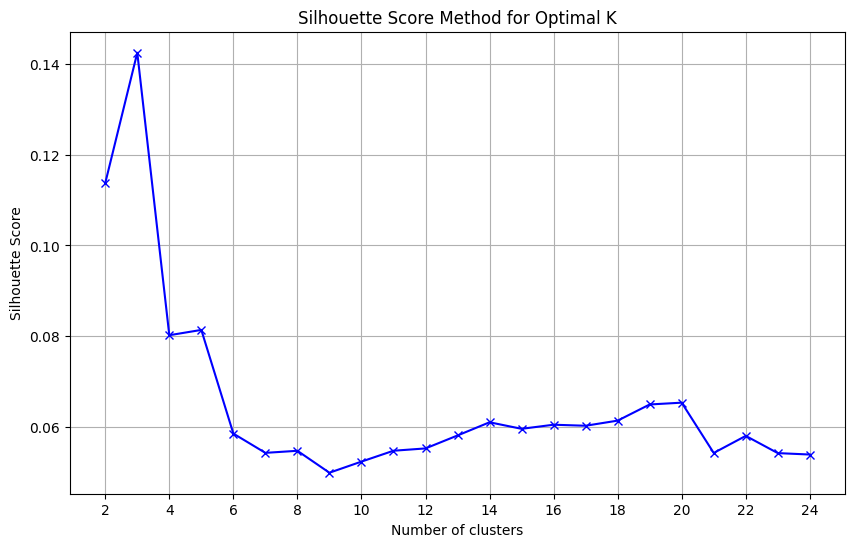

In [182]:
sc = {}

# Iterate for a range of Ks and fit the data to the algorithm. Store the Silhouette score for that K
for k in range(2, 25):
    kmeans = KMeans(n_clusters = k, random_state = 42).fit(skill_vectors)

    labels = kmeans.predict(skill_vectors)

    sc[k] = silhouette_score(skill_vectors, labels)

# Silhouette score plot
plt.figure(figsize=(10, 6))
plt.plot(list(sc.keys()), list(sc.values()), 'bx-')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette Score")
plt.title('Silhouette Score Method for Optimal K')
plt.grid(True)
plt.xticks(k_range[::2])
plt.show()

In [183]:
from sklearn.cluster import KMeans
K = 14
kmeans = KMeans(n_clusters=K, random_state=42, init='k-means++', n_init='auto')

# Fit the model and predict the cluster label for each skill vector
cluster_labels = kmeans.fit_predict(skill_vectors)

# cacculate inertia and silhouette score for the chosen K
inertia_value = kmeans.inertia_
sc_score = silhouette_score(skill_vectors, cluster_labels)
print(f"Inertia for K={K}: {inertia_value}")
print(f"Silhouette Score for K={K}: {sc_score}")

# Create a mapping (Series/Dictionary) from the skill to its cluster ID
skill_to_cluster_id = pd.Series(cluster_labels, index=unique_skills_list)

Inertia for K=14: 9394.189453125
Silhouette Score for K=14: 0.060953106731176376


In [ ]:
# Print clusters and their associated skills
for cluster_id in range(K):
    print(f"Cluster {cluster_id}:")
    cluster_skills = [skill for skill, cluster in skill_to_cluster_id.items() if cluster == cluster_id]
    print(", ".join(cluster_skills))
    print("-" * 50)

Cluster 0:
containerization, containerization technologies
--------------------------------------------------
Cluster 1:
express.js, tableau, s3, lambda, microservices, redux, typescript, react.js, golang, restful apis, docker, graphql, angular, kubernetes, fastapi, tensorflow, pytorch, jenkins, terraform, flexbox, azure databricks, snowflake, scrum, figma, soap, selenium, springboot, kotlin, reactjs, databricks, bigquery, webpack, babel, jasmine, flask, expressjs, laravel, vuejs, vue.js, chef, puppet, ansible, prometheus, grafana, .net, scikit-learn, talend, gitlab, next.js, tailwind, pyspark, bash, devsecops, bamboo, dynamodb, powerbi, vue, ai/ml, gitops, rds, confluence, soql, keras, struts, openshift, fb prophet, gluon, cloudwatch, cloudformation, bootstrap, qlik, iam, submittals
--------------------------------------------------
Cluster 2:
relational databases, data analysis, data warehousing, data analytics, statistics, data visualization tools, big data, data pipelines, database

Low-Effort Feature Creation for Thesis Analysis
The final step - using the clustered results to create quantitative features for the Job Posting Success Prediction model.

Manual Cluster Labeling
This requires the most effort but adds the most value to your thesis.

Action:
Iterate through your 20 clusters, inspect the top 10-20 most representative skills in each, and assign a semantic label.

Feature Mapping and Counting

Use the skill_to_cluster_id mapping to create your new feature columns in the main DataFrame.

Map Cluster Labels: Create a new column in your original DataFrame that lists the cluster IDs (not the raw skills) for each job

In [138]:
# Map each skill to its cluster label
def map_skills_to_clusters(skills_list):
    return [skill_to_cluster_id.get(skill) for skill in skills_list if skill in skill_to_cluster_id]

In [139]:
df_clustered = df_skills.copy()
df_clustered['skill_cluster_ids'] = df_clustered['skills'].apply(map_skills_to_clusters)

In [141]:
pd.set_option('display.max_colwidth', None)
df_clustered.head(5)

,title,description,general job classification,skills,formal_requirements,skill_cluster_ids
0,Full Stack Engineer,"Location: Remote\nCompany Overview:SkillFit, a subsidiary of Ideando Inc. is a cutting-edge AI-powered platform that revolutionizes the talent acquisition process by connecting job seekers with recruiters in a seamless and efficient manner. Our mission is to leverage technology to enhance the job search experience for both candidates and employers, ultimately driving better outcomes and reducing frustration in the hiring process.\nPosition Overview:We are seeking a talented and experienced Freelance Full-Stack Software Engineer to collaborate with our dynamic team on a project basis. The ideal candidate will have a passion for building innovative software solutions, a strong foundation in both front-end and back-end technologies, and a desire to contribute to a fast-paced startup environment.\nKey Responsibilities:1. Collaborate with the product team to understand requirements, design solutions, and implement new features and functionalities for SkillFit's platform.2. Develop robust, scalable, and maintainable code across the full stack, including front-end UI components, back-end services, database integrations and API connectivity.3. Participate in code reviews, architectural discussions, and technical planning sessions to ensure code quality, performance, and adherence to best practices.4. Work closely with cross-functional teams, including product management, design, and QA, to deliver high-quality software solutions that meet user needs and business objectives.5. Identify and address technical challenges and opportunities for improvement, proposing innovative solutions and technologies to enhance the platform's capabilities and performance.6. Contribute to a collaborative and inclusive team culture, sharing knowledge, mentoring junior engineers, and actively participating in team meetings and discussions.\nQualifications:- 3+ years of professional experience in software development, with a focus on full-stack web development.- Proficiency in modern programming languages and frameworks, including JavaScript/TypeScript, React, Node.js, Python, and Express.js.- Experience with relational and NoSQL databases, such as PostgreSQL, MongoDB, or similar.- Strong understanding of web development fundamentals, including HTML5, CSS3, and responsive design principles.- Familiarity with cloud platforms and services, such as AWS, Azure, or Google Cloud Platform.- Knowledge of software engineering best practices, including version control, testing, and continuous integration/continuous deployment (CI/CD) pipelines.- Excellent problem-solving skills, attention to detail, and ability to work independently or as part of a team in a fast-paced, agile environment.- Strong communication and collaboration skills, with the ability to effectively communicate technical concepts to non-technical stakeholders.\nBenefits:- Competitive compensation based on project scope and duration.- Flexible remote work environment with opportunities for collaboration and networking.- Opportunities to work on exciting projects and contribute to innovative solutions in the talent acquisition industry.- Potential for long-term engagement and ongoing project work based on performance and fit.- Professional development opportunities and support for continued learning and skill development.\nJoin us in our mission to transform the talent acquisition industry with innovative technology solutions. We highly encourage you to explore our beta product at https://skillfitai.com/ before submitting your application, allowing you to gain a deeper understanding of our mission and objectives. Become a Freelance Full-Stack Software Engineer at SkillFit and make a meaningful impact on the future of hiring!",Software Development / Engineering,"[full-stack web development, JavaScript/TypeScript, React, Node.js, Python, Express.js, relational databases, NoSQL databases, HTM

In [144]:
# Print cluster IDs for each general job classification
classification_clusters = df_clustered.groupby('general job classification')['skill_cluster_ids'].apply(
    lambda x: set(cluster_id for cluster_list in x for cluster_id in cluster_list if cluster_list)
)

for classification, clusters in classification_clusters.items():
    print(f"General Job Classification: {classification}")
    print(f"Cluster IDs: {sorted(clusters)}")
    print("-" * 50)

General Job Classification: Business Analysis
Cluster IDs: [np.int32(1), np.int32(2), np.int32(4), np.int32(7), np.int32(8), np.int32(10), np.int32(13)]
--------------------------------------------------
General Job Classification: Data & Analytics
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(13)]
--------------------------------------------------
General Job Classification: Project Management
Cluster IDs: [np.int32(1), np.int32(2), np.int32(4), np.int32(7), np.int32(8), np.int32(13)]
--------------------------------------------------
General Job Classification: Software Development / Engineering
Cluster IDs: [np.int32(0), np.int32(1), np.int32(2), np.int32(3), np.int32(4), np.int32(5), np.int32(6), np.int32(7), np.int32(8), np.int32(9), np.int32(10), np.int32(12), np.int32(13)]
--------------------------------------------------
General Job Classification: Technical Architecture
Cluster IDs: 

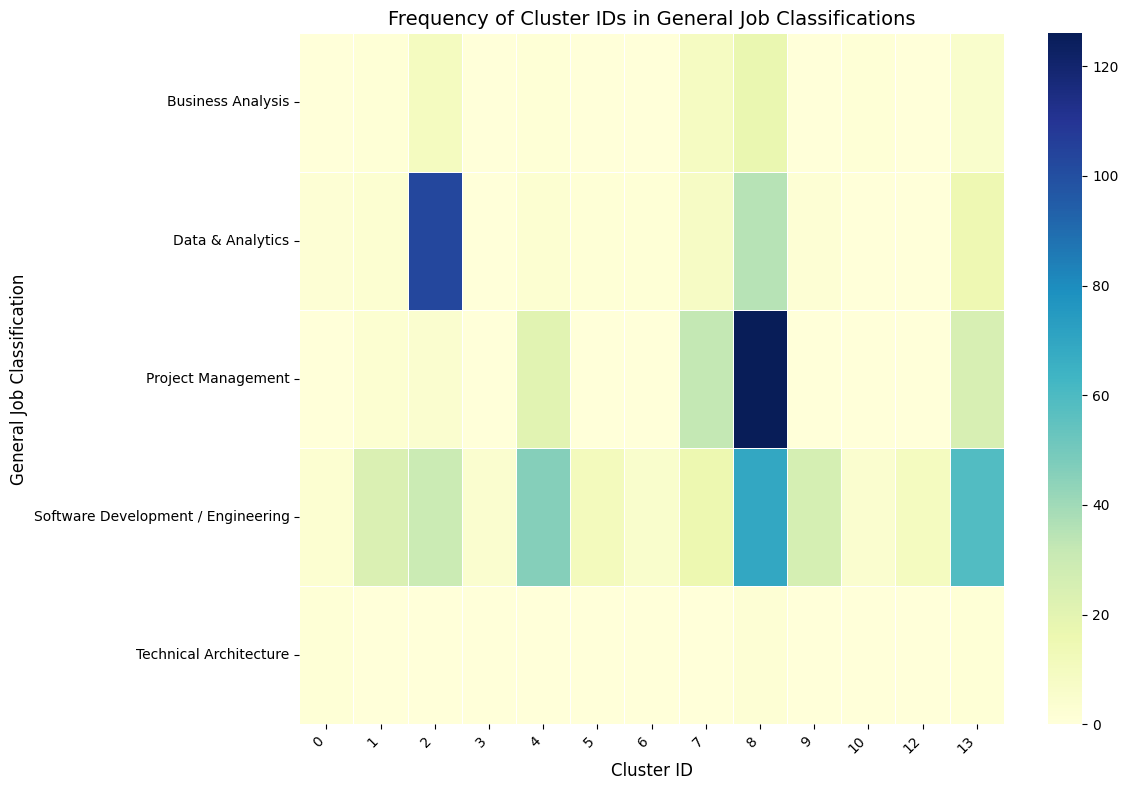

In [145]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the frequency of each cluster ID in each general job classification
cluster_frequency = df_clustered.explode('skill_cluster_ids').groupby(['general job classification', 'skill_cluster_ids']).size().unstack(fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(cluster_frequency, annot=False, cmap="YlGnBu", cbar=True, linewidths=0.5)
plt.title("Frequency of Cluster IDs in General Job Classifications", fontsize=14)
plt.xlabel("Cluster ID", fontsize=12)
plt.ylabel("General Job Classification", fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [168]:
df_clustered.head()

,title,description,general job classification,skills,formal_requirements,skill_cluster_ids
0,Full Stack Engineer,"Location: Remote\nCompany Overview:SkillFit, a subsidiary of Ideando Inc. is a cutting-edge AI-powered platform that revolutionizes the talent acquisition process by connecting job seekers with recruiters in a seamless and efficient manner. Our mission is to leverage technology to enhance the job search experience for both candidates and employers, ultimately driving better outcomes and reducing frustration in the hiring process.\nPosition Overview:We are seeking a talented and experienced Freelance Full-Stack Software Engineer to collaborate with our dynamic team on a project basis. The ideal candidate will have a passion for building innovative software solutions, a strong foundation in both front-end and back-end technologies, and a desire to contribute to a fast-paced startup environment.\nKey Responsibilities:1. Collaborate with the product team to understand requirements, design solutions, and implement new features and functionalities for SkillFit's platform.2. Develop robust, scalable, and maintainable code across the full stack, including front-end UI components, back-end services, database integrations and API connectivity.3. Participate in code reviews, architectural discussions, and technical planning sessions to ensure code quality, performance, and adherence to best practices.4. Work closely with cross-functional teams, including product management, design, and QA, to deliver high-quality software solutions that meet user needs and business objectives.5. Identify and address technical challenges and opportunities for improvement, proposing innovative solutions and technologies to enhance the platform's capabilities and performance.6. Contribute to a collaborative and inclusive team culture, sharing knowledge, mentoring junior engineers, and actively participating in team meetings and discussions.\nQualifications:- 3+ years of professional experience in software development, with a focus on full-stack web development.- Proficiency in modern programming languages and frameworks, including JavaScript/TypeScript, React, Node.js, Python, and Express.js.- Experience with relational and NoSQL databases, such as PostgreSQL, MongoDB, or similar.- Strong understanding of web development fundamentals, including HTML5, CSS3, and responsive design principles.- Familiarity with cloud platforms and services, such as AWS, Azure, or Google Cloud Platform.- Knowledge of software engineering best practices, including version control, testing, and continuous integration/continuous deployment (CI/CD) pipelines.- Excellent problem-solving skills, attention to detail, and ability to work independently or as part of a team in a fast-paced, agile environment.- Strong communication and collaboration skills, with the ability to effectively communicate technical concepts to non-technical stakeholders.\nBenefits:- Competitive compensation based on project scope and duration.- Flexible remote work environment with opportunities for collaboration and networking.- Opportunities to work on exciting projects and contribute to innovative solutions in the talent acquisition industry.- Potential for long-term engagement and ongoing project work based on performance and fit.- Professional development opportunities and support for continued learning and skill development.\nJoin us in our mission to transform the talent acquisition industry with innovative technology solutions. We highly encourage you to explore our beta product at https://skillfitai.com/ before submitting your application, allowing you to gain a deeper understanding of our mission and objectives. Become a Freelance Full-Stack Software Engineer at SkillFit and make a meaningful impact on the future of hiring!",Software Development / Engineering,"[full-stack web development, JavaScript/TypeScript, React, Node.js, Python, Express.js, relational databases, NoSQL databases, HTM

In [169]:
df_clustered.shape

(739, 6)

In [184]:
from sklearn.decomposition import PCA
import pandas as pd

# Reduce the 300-dimensional vectors to 2 dimensions
pca = PCA(n_components=2, random_state=42)
skill_vectors_2d = pca.fit_transform(skill_vectors)

# Create a DataFrame for easy plotting
pca_df = pd.DataFrame(skill_vectors_2d, columns=['PC1', 'PC2'])
# Add the cluster labels to the DataFrame
pca_df['Cluster'] = cluster_labels

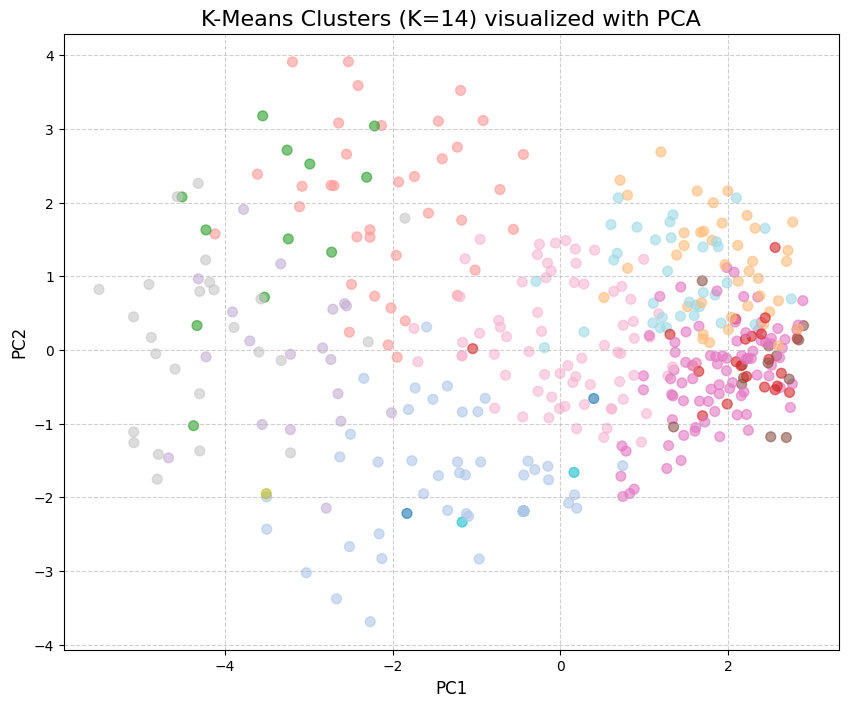

In [185]:
import matplotlib.pyplot as plt

# Assuming you used PCA and the DataFrame is called pca_df
df_to_plot = pca_df # or tsne_df

plt.figure(figsize=(10, 8))
scatter = plt.scatter(
    df_to_plot.iloc[:, 0], # x-axis: PC1 or tSNE-1
    df_to_plot.iloc[:, 1], # y-axis: PC2 or tSNE-2
    c=df_to_plot['Cluster'], # Color points by cluster label
    cmap='tab20', # Choose a color map with many distinct colors (K=14)
    s=50, # Marker size
    alpha=0.6 # Transparency
)

# Add title and labels based on the reduction method used
plt.title(f'K-Means Clusters (K={K}) visualized with PCA', fontsize=16)
plt.xlabel(df_to_plot.columns[0], fontsize=12)
plt.ylabel(df_to_plot.columns[1], fontsize=12)

# Add a legend
legend1 = plt.legend(*scatter.legend_elements(),
                    title="Cluster ID",
                    loc="lower right",
                    bbox_to_anchor=(1.25, 0))
plt.gca().add_artist(legend1)

plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
#

# Second clustering approach - TF-IDF Vectorization

# NOT NEEDED NOW - CREATING FEATURES AFTER CLUSTERING

In [167]:
# what clusters are repeated across general job classification
# Create binary features for each cluster
def create_cluster_features(cluster_ids, K):
    features = np.zeros(K)
    for cid in cluster_ids:
        if cid is not None and 0 <= cid < K:
            features[cid] = 1
    return features
cluster_features = df_clustered['skill_cluster_ids'].apply(lambda ids: create_cluster_features(ids, K))


In [166]:
cluster_features

0      [0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
1      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0]
2      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0]
3      [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
4      [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
                                        ...                                  
734    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
735    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
736    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
737    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0]
738    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0]
Name: skill_cluster_ids, Length: 739, dtype: object

Generate Count Features: Use one-hot encoding or counting to create a feature for each cluster category. This is the final, most valuable feature set for your prediction model.

In [109]:
# Explode the cluster IDs and count their frequency per job posting
cluster_counts = df_clustered.explode('skill_cluster_ids').groupby(level=0)['skill_cluster_ids'].value_counts()

# Unstack the data to get one column per cluster, with the count as the value
cluster_features = cluster_counts.unstack(fill_value=0)

# Merge the new features back into your main DataFrame
df_clustered = df_clustered.join(cluster_features)

# You can now rename the new columns (0, 1, 2...) to your human-assigned labels
df_clustered.rename(columns={i: cluster_labels[i] for i in range(K)}, inplace=True)

### NEXT STEPS

Job Posting Success Prediction - wohoooo next step

Understanding Sentiment in Job Descriptions

Tracking Changes in Skills Demand in Job Postings